# Resumen del trabajo realizado

In [1]:
import transformData as td
import matplotlib.pyplot as plt
import numpy as np
import pycblosc2 as cb2
import time as t
from math import log

## Definicición del conjunto de datos

In [129]:
image = (plt.imread("../../data/chessg.png")*255).astype(np.uint8).view(np.uint32)

h = len(image)
w = len(image[0])

image =  image.reshape(h, w)

BYTES_SIZE = image.size * image.dtype.itemsize

## Transformación del conjunto de datos

In [144]:
start = t.perf_counter()

subshape = [1024, 32]
imageT = td.t_dataC_simple(image, subshape, inverse=False)

end = t.perf_counter()

ttransform = end - start

## Compresión del conjunto de datos (aplicando shuffle iterativo) 

### Definición de los parámetros

In [145]:
KB = 1024
MB = 1024 * KB
GB = 1024 * MB

BLOSC_MAX_FILTERS = 5
BLOSC_BLOCKSIZE = 16 * KB
BLOSC_TYPESIZE = 4
BLOSC_CODE = 1

cparams = cb2.blosc2_create_cparams(compcode=BLOSC_CODE, clevel=5, use_dict=0, typesize=BLOSC_TYPESIZE,
                                        nthreads=4, blocksize= BLOSC_BLOCKSIZE, schunk=None,
                                        filters=[0, 0, 0, 0, 0],
                                        filters_meta=[0, 0, 0, 0, 0])

dparams = cb2.blosc2_create_dparams(nthreads=4, schunk=None)

### Compresión del conjunto de datos

In [147]:
# CÁLCULO DEL ORDEN DE LA PERMUTACIÓN

SIZE = BLOSC_BLOCKSIZE  / BLOSC_TYPESIZE
TAM = BLOSC_TYPESIZE

if  log(SIZE, 2) % log(TAM, 2) == 0:
    orden = int(log(SIZE, TAM) + 1)
else:
    orden = int(log(SIZE, 2) + log(TAM, 2))

nIters = range(orden + 1)



# COMPRESIÓN DE LA IMAGEN SIN TRANSFORMAR

ratios = []

# Compresión sin shuffle

start = t.perf_counter()

cparams.filters[BLOSC_MAX_FILTERS - 1] = 0

schunk = cb2.blosc2_new_schunk(cparams, dparams)
nchunks = cb2.blosc2_append_buffer(schunk, BYTES_SIZE, image)

end = t.perf_counter()

nbytes = schunk.nbytes
cbytes = schunk.cbytes
cb2.blosc2_free_schunk(schunk)

r = (1. * nbytes) / cbytes

ratios.append(r)

ttotal = end - start

# Compresión con el shuffle iterativo

cparams.filters[BLOSC_MAX_FILTERS - 1] = 1

for i in range(orden):
    cparams.filters_meta[BLOSC_MAX_FILTERS - 1] = i
    schunk = cb2.blosc2_new_schunk(cparams, dparams)
    nchunks = cb2.blosc2_append_buffer(schunk, BYTES_SIZE, image)
    nbytes = schunk.nbytes
    cbytes = schunk.cbytes
    cb2.blosc2_free_schunk(schunk)

    r = (1. * nbytes) / cbytes

    ratios.append(r)
    

    
# COMPRESIÓN DE LA IMAGEN TRANSFORMADA

ratiosT = []

# Compresión sin shuffle

start = t.perf_counter()

cparams.filters[BLOSC_MAX_FILTERS - 1] = 0

schunk = cb2.blosc2_new_schunk(cparams, dparams)
nchunks = cb2.blosc2_append_buffer(schunk, BYTES_SIZE, imageT)

end = t.perf_counter()

nbytes = schunk.nbytes
cbytes = schunk.cbytes
cb2.blosc2_free_schunk(schunk)

r = (1. * nbytes) / cbytes

ratiosT.append(r)

ttotalT = end - start + ttransform

# Compresión con el shuffle iterativo

cparams.filters[BLOSC_MAX_FILTERS - 1] = 1

for i in range(orden):
    cparams.filters_meta[BLOSC_MAX_FILTERS - 1] = i
    schunk = cb2.blosc2_new_schunk(cparams, dparams)
    nchunks = cb2.blosc2_append_buffer(schunk, BYTES_SIZE, imageT)
    nbytes = schunk.nbytes
    cbytes = schunk.cbytes
    cb2.blosc2_free_schunk(schunk)

    r = (1. * nbytes) / cbytes

    ratiosT.append(r)

## Impresión de los resultados

### Conjunto de datos analizados

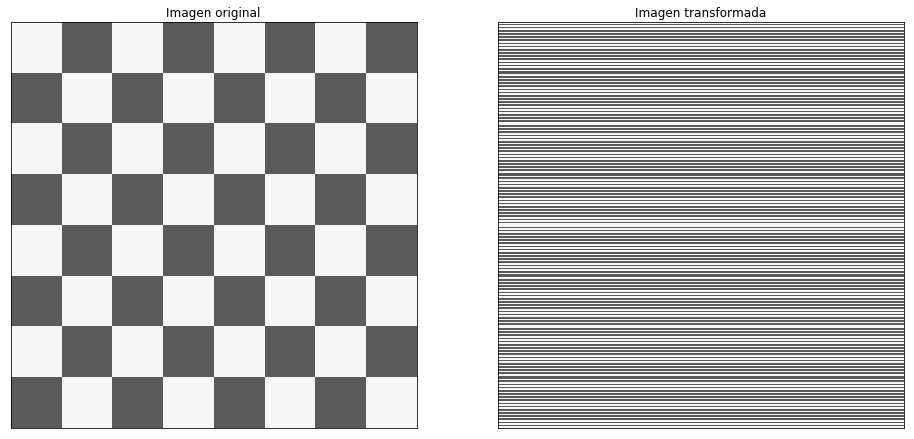

In [138]:
f, axarr = plt.subplots(1, 2, figsize=(16,8))
axarr[0].imshow(image.reshape(h, w, 1).view(np.uint8)[:,:,:], cmap='binary')
axarr[0].set_title("Imagen original")
axarr[0].xaxis.set_major_locator(plt.NullLocator())
axarr[0].yaxis.set_major_locator(plt.NullLocator())

axarr[1].imshow(imageT.reshape(h, w, 1).view(np.uint8)[:,:,:], cmap='binary')
axarr[1].set_title("Imagen transformada")
axarr[1].xaxis.set_major_locator(plt.NullLocator())
axarr[1].yaxis.set_major_locator(plt.NullLocator())

plt.show()

### Resultados de compresión

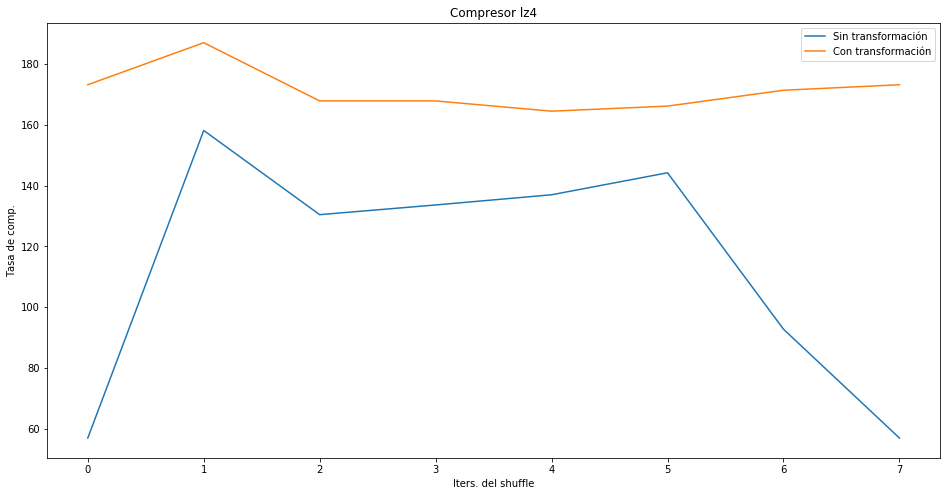

La tasa de compresión de los datos transformados es 1.18 veces mejor que la tasa de la imagen original.


In [143]:
fig = plt.figure(figsize=(16, 8))

plt.plot(nIters, ratios, label = "Sin transformación")
plt.plot(nIters, ratiosT, label = "Con transformación")

plt.ylabel("Tasa de comp.")
plt.xlabel("Iters. del shuffle")
plt.title("Compresor " + cb2.blosc_compcode_to_compname(BLOSC_CODE)[1])
plt.legend(loc = "upper right")
           
plt.show()

f = max(ratiosT)/max(ratios)
print("La tasa de compresión de los datos transformados es {:.2f} veces"
      " mejor que la tasa de la imagen original.".format(f))

### Tiempo empleado para la compresión

In [148]:
print("La compresión de la imagen original ha costado {:.3f} segundos.".format(ttotal))
print("La compresión de la imagen transformada ha costado {:.3f} segundos.".format(ttotalT))

La compresión de la imagen original ha costado 0.002 segundos.
La compresión de la imagen transformada ha costado 0.302 segundos.
